In [178]:
#import modules

#SKLearn
import sklearn.model_selection as sk
import sklearn.metrics as m
from sklearn import ensemble as e
from sklearn import svm, linear_model, cluster
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

#Else
import sys
import pandas as pd
import math
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('default')

#full dfs
%store -r df 
%store -r scaled_df
%store -r fe_df
%store -r df_upsampled

%store -r x_tr
%store -r y_tr
%store -r x_te
%store -r y_te

%store -r xs_tr
%store -r ys_tr
%store -r xs_te
%store -r ys_te

%store -r x_fetr
%store -r y_fetr
%store -r x_fete
%store -r y_fete
%store -r xs_fetr
%store -r ys_fetr
%store -r xs_fete
%store -r ys_fete

%store -r x_uptr
%store -r y_uptr
%store -r x_upte
%store -r y_upte
%store -r xs_uptr
%store -r ys_uptr
%store -r xs_upte
%store -r ys_upte

%store -r cols
%store -r fe_cols
%store -r testsizepercent


# Model Baselines

- Based off of x,y | x_sc, y_sc | fe_x, fe_y | up_x, up_y
    - using prestored training/testing splits

- Hyperparameter settings: All default except kernels/criterion/solvers

## Functions

In [179]:
#Baseline functions
%matplotlib inline

def threshold(val, posval):
    return [1 if i>posval else 0 for i in val]

def plotAUC(truth, pred, lab, thresh):
    fpr, tpr, thresholds = m.roc_curve(truth, threshold(pred, thresh))
    roc_auc = m.auc(fpr, tpr)
    c = (np.random.rand(), np.random.rand(), np.random.rand())
    plt.plot(fpr, tpr, color=c, label= lab+' (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC')
    plt.legend(loc="lower right")
    rets =  [fpr, tpr]
    return



def plot_scores(truth, pred, lab, thresh, rnd, out=False):
    #Scores
    acc_score = m.accuracy_score(truth, threshold(pred, thresh), normalize=True).round(rnd)
    prec_score = m.precision_score(truth, threshold(pred, thresh)).round(rnd)
    rec_score = m.recall_score(truth, threshold(pred, thresh)).round(rnd)
    f_score = m.f1_score(truth, threshold(pred, thresh)).round(rnd)
    avg_precision = m.average_precision_score(truth, threshold(pred, thresh)).round(rnd)
    rets = [acc_score, prec_score, rec_score, f_score, avg_precision]
    if out==True:
        print(lab, 'Average accuracy score: {0:0.2f}'.format(acc_score))
        print(lab, 'Average precision score: {0:0.2f}'.format(prec_score))
        print(lab, 'Average recall score: {0:0.2f}'.format(rec_score))
        print(lab, 'Average F1 score: {0:0.2f}'.format(f_score))
        print(lab, 'Average precision-recall score: {0:0.2f}'.format(avg_precision))
        print("---")
    return rets



#Baseline Parameters
th = .8 #threshold
sd = 4  #significant digit

%store th
%store sd

Stored 'th' (float)
Stored 'sd' (int)


## MODELS

    - std -> standard data
    - scl -> normalized data
    - fe -> feature engineered data
    - up -> upsampled data

## Decision Tree

- Doesnt need scaled
- entropy criterion

In [180]:
#Decision Tree
dt_s = DecisionTreeClassifier(criterion='entropy').fit(x_tr, y_tr)
dt_fe = DecisionTreeClassifier(criterion='entropy').fit(x_fetr, y_fetr)
dt_up = DecisionTreeClassifier(criterion='entropy').fit(x_uptr, y_uptr)

DT - std Average accuracy score: 0.81
DT - std Average precision score: 0.86
DT - std Average recall score: 0.86
DT - std Average F1 score: 0.86
DT - std Average precision-recall score: 0.83
---
DT - fe Average accuracy score: 0.82
DT - fe Average precision score: 0.86
DT - fe Average recall score: 0.85
DT - fe Average F1 score: 0.86
DT - fe Average precision-recall score: 0.83
---
DT - up Average accuracy score: 0.90
DT - up Average precision score: 0.94
DT - up Average recall score: 0.86
DT - up Average F1 score: 0.90
DT - up Average precision-recall score: 0.88
---


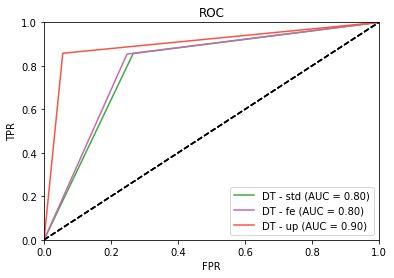

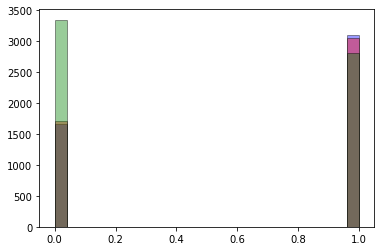

In [181]:
#Readouts
a = plot_scores(y_te, dt_s.predict_proba(x_te)[:,1], 
                'DT - std', th, sd, out=True)
b = plot_scores(y_fete, dt_fe.predict_proba(x_fete)[:,1], 
                'DT - fe', th, sd, out=True)
c = plot_scores(y_upte, dt_up.predict_proba(x_upte)[:,1], 
                'DT - up', th, sd, out=True)

#AUC Plot
plotAUC(y_te, dt_s.predict_proba(x_te)[:,1], 'DT - std', th)
plotAUC(y_fete, dt_fe.predict_proba(x_fete)[:,1], 'DT - fe', th)
plotAUC(y_upte, dt_up.predict_proba(x_upte)[:,1], 'DT - up', th)
plt.show()

#Guess Distribution
sns.distplot(dt_s.predict_proba(x_te)[:,1], hist=True, kde=False, 
             bins=int(25), color = 'blue',
             hist_kws={'edgecolor':'black'})
sns.distplot(dt_fe.predict_proba(x_fete)[:,1], hist=True, kde=False, 
             bins=int(25), color = 'red',
             hist_kws={'edgecolor':'black'})
sns.distplot(dt_up.predict_proba(x_upte)[:,1], hist=True, kde=False, 
             bins=int(25), color = 'green',
             hist_kws={'edgecolor':'black'})
plt.show()

## Logistic Regression

- Scaled: std, feat, upsampled
- solver=lbfgs, C=1, max_iter=200 b

In [182]:
lr_s = linear_model.LogisticRegression(solver='liblinear', 
                                       C=1, 
                                       max_iter=200).fit(xs_tr, ys_tr)

lr_fe = linear_model.LogisticRegression(solver='liblinear', 
                                       C=1, 
                                       max_iter=200).fit(xs_fetr, ys_fetr)

lr_up = linear_model.LogisticRegression(solver='liblinear', 
                                       C=1, 
                                       max_iter=200).fit(xs_uptr, ys_uptr)



LR - std Average accuracy score: 0.70
LR - std Average precision score: 0.89
LR - std Average recall score: 0.62
LR - std Average F1 score: 0.73
LR - std Average precision-recall score: 0.80
---
LR - fe Average accuracy score: 0.72
LR - fe Average precision score: 0.90
LR - fe Average recall score: 0.63
LR - fe Average F1 score: 0.74
LR - fe Average precision-recall score: 0.81
---
LR - up Average accuracy score: 0.64
LR - up Average precision score: 0.87
LR - up Average recall score: 0.33
LR - up Average F1 score: 0.48
LR - up Average precision-recall score: 0.62
---


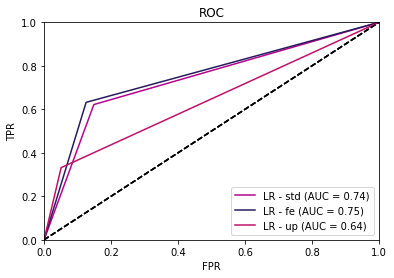

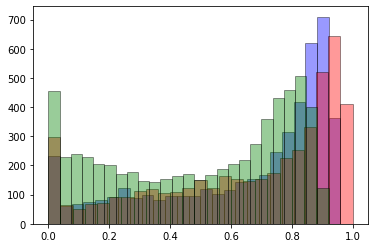

In [183]:
#Readouts
a = plot_scores(ys_te, lr_s.predict_proba(xs_te)[:,1], 
                'LR - std', th, sd, out=True)
b = plot_scores(ys_fete, lr_fe.predict_proba(xs_fete)[:,1], 
                'LR - fe', th, sd, out=True)
c = plot_scores(ys_upte, lr_up.predict_proba(xs_upte)[:,1], 
                'LR - up', th, sd, out=True)

#AUC Plot
plotAUC(ys_te, lr_s.predict_proba(xs_te)[:,1], 'LR - std', th)
plotAUC(ys_fete, lr_fe.predict_proba(xs_fete)[:,1], 'LR - fe', th)
plotAUC(ys_upte, lr_up.predict_proba(xs_upte)[:,1], 'LR - up', th)
plt.show()

#Guess Distribution
sns.distplot(lr_s.predict_proba(xs_te)[:,1], hist=True, kde=False, 
             bins=int(25), color = 'blue',
             hist_kws={'edgecolor':'black'})
sns.distplot(lr_fe.predict_proba(xs_fete)[:,1], hist=True, kde=False, 
             bins=int(25), color = 'red',
             hist_kws={'edgecolor':'black'})
sns.distplot(lr_up.predict_proba(xs_upte)[:,1], hist=True, kde=False, 
             bins=int(25), color = 'green',
             hist_kws={'edgecolor':'black'})
plt.show()

## Random Forest

- Doesnt need ot be scaled
- criterion = entropy, n_estimators=100 (new default)

In [184]:
#Random Forest
rf_s = e.RandomForestClassifier(criterion='entropy', 
                                n_estimators=100).fit(x_tr, y_tr)

rf_fe = e.RandomForestClassifier(criterion='entropy', 
                                n_estimators=100).fit(x_fetr, y_fetr)

rf_up = e.RandomForestClassifier(criterion='entropy', 
                                n_estimators=100).fit(x_uptr, y_uptr)

RF - std Average accuracy score: 0.80
RF - std Average precision score: 0.95
RF - std Average recall score: 0.74
RF - std Average F1 score: 0.83
RF - std Average precision-recall score: 0.87
---
RF - fe Average accuracy score: 0.80
RF - fe Average precision score: 0.94
RF - fe Average recall score: 0.73
RF - fe Average F1 score: 0.82
RF - fe Average precision-recall score: 0.86
---
RF - up Average accuracy score: 0.84
RF - up Average precision score: 0.98
RF - up Average recall score: 0.69
RF - up Average F1 score: 0.81
RF - up Average precision-recall score: 0.83
---


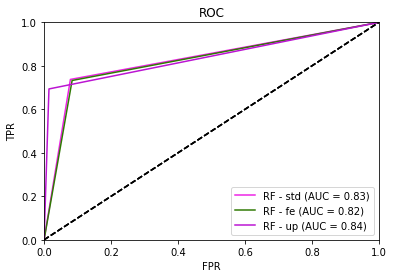

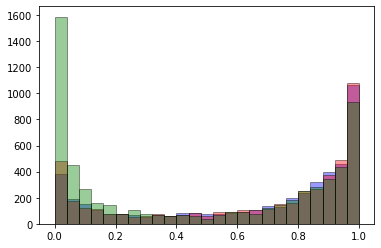

In [185]:
#Readouts
a = plot_scores(y_te, rf_s.predict_proba(x_te)[:,1], 
                'RF - std', th, sd, out=True)
b = plot_scores(y_fete, rf_fe.predict_proba(x_fete)[:,1], 
                'RF - fe', th, sd, out=True)
c = plot_scores(y_upte, rf_up.predict_proba(x_upte)[:,1], 
                'RF - up', th, sd, out=True)

#AUC Plot
plotAUC(y_te, rf_s.predict_proba(x_te)[:,1], 'RF - std', th)
plotAUC(y_fete, rf_fe.predict_proba(x_fete)[:,1], 'RF - fe', th)
plotAUC(y_upte, rf_up.predict_proba(x_upte)[:,1], 'RF - up', th)
plt.show()

#Guess Distribution
sns.distplot(rf_s.predict_proba(x_te)[:,1], hist=True, kde=False, 
             bins=int(25), color = 'blue',
             hist_kws={'edgecolor':'black'})
sns.distplot(rf_fe.predict_proba(x_fete)[:,1], hist=True, kde=False, 
             bins=int(25), color = 'red',
             hist_kws={'edgecolor':'black'})
sns.distplot(rf_up.predict_proba(x_upte)[:,1], hist=True, kde=False, 
             bins=int(25), color = 'green',
             hist_kws={'edgecolor':'black'})
plt.show()

# With Bagging

- experimented with, took long to train -> very long to cross validate for params

- can show baselines

In [186]:
bag_rfs = e.BaggingClassifier(rf_s).fit(x_tr, y_tr)
bag_rffe = e.BaggingClassifier(rf_fe).fit(x_fetr, y_fetr)
bag_rfup = e.BaggingClassifier(rf_up).fit(x_uptr, y_uptr)

bRF - std Average accuracy score: 0.80
bRF - std Average precision score: 0.95
bRF - std Average recall score: 0.73
bRF - std Average F1 score: 0.83
bRF - std Average precision-recall score: 0.87
---
bRF - fe Average accuracy score: 0.79
bRF - fe Average precision score: 0.94
bRF - fe Average recall score: 0.73
bRF - fe Average F1 score: 0.82
bRF - fe Average precision-recall score: 0.86
---
bRF - up Average accuracy score: 0.81
bRF - up Average precision score: 0.98
bRF - up Average recall score: 0.64
bRF - up Average F1 score: 0.78
bRF - up Average precision-recall score: 0.81
---


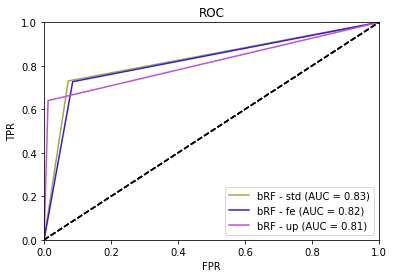

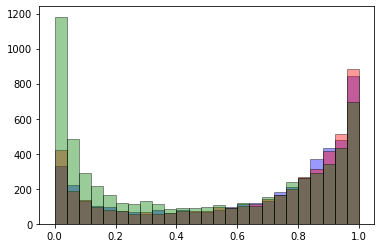

In [187]:
#Readouts
a = plot_scores(y_te, bag_rfs.predict_proba(x_te)[:,1], 
                'bRF - std', th, sd, out=True)
b = plot_scores(y_fete, bag_rffe.predict_proba(x_fete)[:,1], 
                'bRF - fe', th, sd, out=True)
c = plot_scores(y_upte, bag_rfup.predict_proba(x_upte)[:,1], 
                'bRF - up', th, sd, out=True)

#AUC Plot
plotAUC(y_te, bag_rfs.predict_proba(x_te)[:,1], 'bRF - std', th)
plotAUC(y_fete, bag_rffe.predict_proba(x_fete)[:,1], 'bRF - fe', th)
plotAUC(y_upte, bag_rfup.predict_proba(x_upte)[:,1], 'bRF - up', th)
plt.show()

#Guess Distribution
sns.distplot(bag_rfs.predict_proba(x_te)[:,1], hist=True, kde=False, 
             bins=int(25), color = 'blue',
             hist_kws={'edgecolor':'black'})
sns.distplot(bag_rffe.predict_proba(x_fete)[:,1], hist=True, kde=False, 
             bins=int(25), color = 'red',
             hist_kws={'edgecolor':'black'})
sns.distplot(bag_rfup.predict_proba(x_upte)[:,1], hist=True, kde=False, 
             bins=int(25), color = 'green',
             hist_kws={'edgecolor':'black'})
plt.show()

## SVM

- same story as Bagging

In [188]:
sv_l_s = svm.SVC(kernel='linear', C=.05).fit(xs_tr, ys_tr)
sv_l_fe = svm.SVC(kernel='linear', C=.05).fit(xs_fetr, ys_fetr)
sv_l_up = svm.SVC(kernel='linear', C=.05).fit(xs_uptr, ys_uptr)

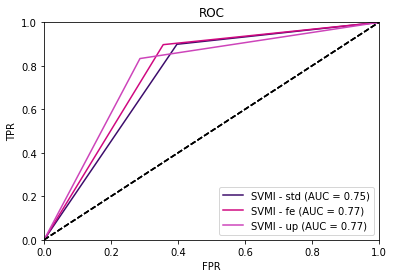

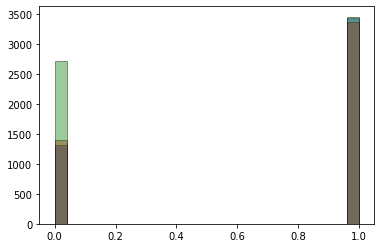

In [189]:
#Readouts
a = plot_scores(ys_te, sv_l_s.predict(xs_te), 
                'SVMl - std', th, sd, out=False)
b = plot_scores(ys_fete, sv_l_fe.predict(xs_fete), 
                'SVMl - fe', th, sd, out=False)
c = plot_scores(ys_upte, sv_l_up.predict(xs_upte), 
                'SVMl - up', th, sd, out=False)

#AUC Plot
plotAUC(ys_te, sv_l_s.predict(xs_te), 'SVMl - std', th)
plotAUC(ys_fete, sv_l_fe.predict(xs_fete), 'SVMl - fe', th)
plotAUC(ys_upte, sv_l_up.predict(xs_upte), 'SVMl - up', th)
plt.show()

#Guess Distribution
sns.distplot(sv_l_s.predict(xs_te), hist=True, kde=False, 
             bins=int(25), color = 'blue',
             hist_kws={'edgecolor':'black'})
sns.distplot(sv_l_fe.predict(xs_fete), hist=True, kde=False, 
             bins=int(25), color = 'red',
             hist_kws={'edgecolor':'black'})
sns.distplot(sv_l_up.predict(xs_upte), hist=True, kde=False, 
             bins=int(25), color = 'green',
             hist_kws={'edgecolor':'black'})
plt.show()

In [190]:
sv_p_s = svm.SVC(kernel='poly', 
                 gamma='scale', 
                 C=.05).fit(xs_tr, ys_tr)
sv_p_fe = svm.SVC(kernel='poly', 
                  gamma='scale', 
                  C=.05).fit(xs_fetr, ys_fetr)
sv_p_up = svm.SVC(kernel='poly', 
                  gamma='scale', 
                  C=.05).fit(xs_uptr, ys_uptr)

SVMp - std Average accuracy score: 0.77
SVMp - std Average precision score: 0.74
SVMp - std Average recall score: 0.98
SVMp - std Average F1 score: 0.84
SVMp - std Average precision-recall score: 0.74
---
SVMp - fe Average accuracy score: 0.75
SVMp - fe Average precision score: 0.73
SVMp - fe Average recall score: 0.98
SVMp - fe Average F1 score: 0.83
SVMp - fe Average precision-recall score: 0.73
---
SVMp - up Average accuracy score: 0.72
SVMp - up Average precision score: 0.66
SVMp - up Average recall score: 0.93
SVMp - up Average F1 score: 0.77
SVMp - up Average precision-recall score: 0.65
---


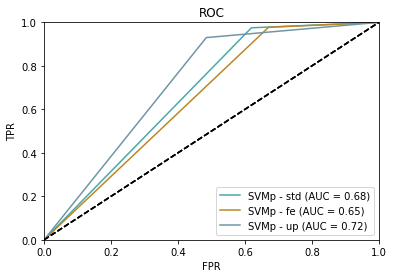

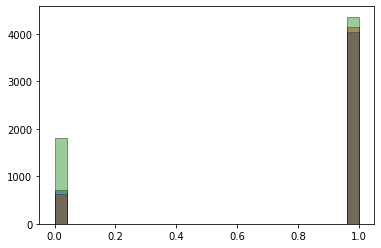

In [191]:
#Readouts
a = plot_scores(ys_te, sv_p_s.predict(xs_te), 
                'SVMp - std', th, sd, out=True)
b = plot_scores(ys_fete, sv_p_fe.predict(xs_fete), 
                'SVMp - fe', th, sd, out=True)
c = plot_scores(ys_upte, sv_p_up.predict(xs_upte), 
                'SVMp - up', th, sd, out=True)

#AUC Plot
plotAUC(ys_te, sv_p_s.predict(xs_te), 'SVMp - std', th)
plotAUC(ys_fete, sv_p_fe.predict(xs_fete), 'SVMp - fe', th)
plotAUC(ys_upte, sv_p_up.predict(xs_upte), 'SVMp - up', th)
plt.show()

#Guess Distribution
sns.distplot(sv_p_s.predict(xs_te), hist=True, kde=False, 
             bins=int(25), color = 'blue',
             hist_kws={'edgecolor':'black'})
sns.distplot(sv_p_fe.predict(xs_fete), hist=True, kde=False, 
             bins=int(25), color = 'red',
             hist_kws={'edgecolor':'black'})
sns.distplot(sv_p_up.predict(xs_upte), hist=True, kde=False, 
             bins=int(25), color = 'green',
             hist_kws={'edgecolor':'black'})
plt.show()

## ADA Boosting & GB Boosting

- ada is a mess - disregarding 

- GB is alright - disregard for paper
    - scaled: s, fe, up
    - n_estimators=100

### Gradient Boosting

In [192]:
gb_s = e.GradientBoostingClassifier(n_estimators=100).fit(xs_tr, ys_tr)
gb_fe = e.GradientBoostingClassifier(n_estimators=100).fit(xs_fetr, ys_fetr)
gb_up = e.GradientBoostingClassifier(n_estimators=100).fit(xs_uptr, ys_uptr)

GB - std Average accuracy score: 0.80
GB - std Average precision score: 0.93
GB - std Average recall score: 0.76
GB - std Average F1 score: 0.83
GB - std Average precision-recall score: 0.86
---
GB - fe Average accuracy score: 0.80
GB - fe Average precision score: 0.93
GB - fe Average recall score: 0.75
GB - fe Average F1 score: 0.83
GB - fe Average precision-recall score: 0.86
---
GB - up Average accuracy score: 0.76
GB - up Average precision score: 0.93
GB - up Average recall score: 0.57
GB - up Average F1 score: 0.71
GB - up Average precision-recall score: 0.74
---


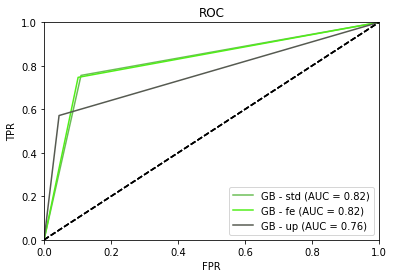

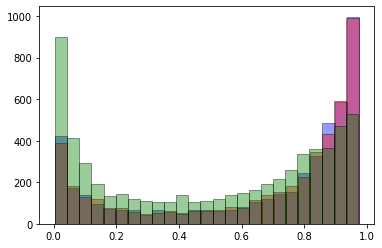

In [193]:
#Regbouts
a = plot_scores(ys_te, gb_s.predict_proba(xs_te)[:,1], 
                'GB - std', th, sd, out=True)
b = plot_scores(ys_fete, gb_fe.predict_proba(xs_fete)[:,1], 
                'GB - fe', th, sd, out=True)
c = plot_scores(ys_upte, gb_up.predict_proba(xs_upte)[:,1], 
                'GB - up', th, sd, out=True)

#AUC Plot
plotAUC(ys_te, gb_s.predict_proba(xs_te)[:,1], 'GB - std', th)
plotAUC(ys_fete, gb_fe.predict_proba(xs_fete)[:,1], 'GB - fe', th)
plotAUC(ys_upte, gb_up.predict_proba(xs_upte)[:,1], 'GB - up', th)
plt.show()

#Guess Distribution
sns.distplot(gb_s.predict_proba(xs_te)[:,1], hist=True, kde=False, 
             bins=int(25), color = 'blue',
             hist_kws={'edgecolor':'black'})
sns.distplot(gb_fe.predict_proba(xs_fete)[:,1], hist=True, kde=False, 
             bins=int(25), color = 'red',
             hist_kws={'edgecolor':'black'})
sns.distplot(gb_up.predict_proba(xs_upte)[:,1], hist=True, kde=False, 
             bins=int(25), color = 'green',
             hist_kws={'edgecolor':'black'})

## K Nearest Neighbors

- Scaled: std, feat, upsampled
- n_neighbors=10, p=2

In [194]:
#K-Nearest Neighbors
knn_s = KNeighborsClassifier(n_neighbors=10, p=2).fit(xs_tr, ys_tr)
knn_fe = KNeighborsClassifier(n_neighbors=10, p=2).fit(xs_fetr, ys_fetr)
knn_up = KNeighborsClassifier(n_neighbors=10, p=2).fit(xs_uptr, ys_uptr)

kNN - std Average accuracy score: 0.76
kNN - std Average precision score: 0.91
kNN - std Average recall score: 0.69
kNN - std Average F1 score: 0.79
kNN - std Average precision-recall score: 0.83
---
kNN - fe Average accuracy score: 0.75
kNN - fe Average precision score: 0.92
kNN - fe Average recall score: 0.68
kNN - fe Average F1 score: 0.78
kNN - fe Average precision-recall score: 0.83
---
kNN - up Average accuracy score: 0.78
kNN - up Average precision score: 0.95
kNN - up Average recall score: 0.59
kNN - up Average F1 score: 0.72
kNN - up Average precision-recall score: 0.76
---


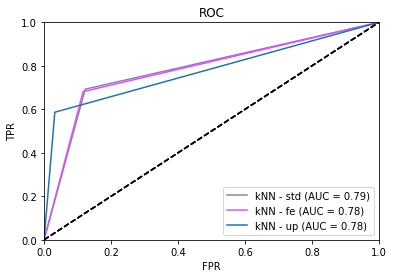

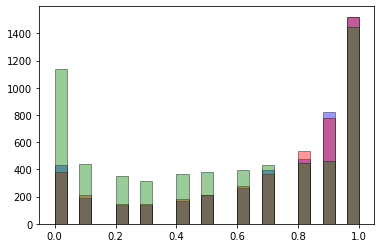

In [195]:
#Readouts
a = plot_scores(ys_te, knn_s.predict_proba(xs_te)[:,1], 
                'kNN - std', th, sd, out=True)
b = plot_scores(ys_fete, knn_fe.predict_proba(xs_fete)[:,1], 
                'kNN - fe', th, sd, out=True)
c = plot_scores(ys_upte, knn_up.predict_proba(xs_upte)[:,1], 
                'kNN - up', th, sd, out=True)

#AUC Plot
plotAUC(ys_te, knn_s.predict_proba(xs_te)[:,1], 'kNN - std', th)
plotAUC(ys_fete, knn_fe.predict_proba(xs_fete)[:,1], 'kNN - fe', th)
plotAUC(ys_upte, knn_up.predict_proba(xs_upte)[:,1], 'kNN - up', th)
plt.show()

#Guess Distribution
sns.distplot(knn_s.predict_proba(xs_te)[:,1], hist=True, kde=False, 
             bins=int(25), color = 'blue',
             hist_kws={'edgecolor':'black'})
sns.distplot(knn_fe.predict_proba(xs_fete)[:,1], hist=True, kde=False, 
             bins=int(25), color = 'red',
             hist_kws={'edgecolor':'black'})
sns.distplot(knn_up.predict_proba(xs_upte)[:,1], hist=True, kde=False, 
             bins=int(25), color = 'green',
             hist_kws={'edgecolor':'black'})